# Examine relationship between Pitch Events and Action Index

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pybaseball import team_game_logs
from pybaseball import team_ids

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


import statsmodels.api as sm
import statsmodels.tools.eval_measures as sme

import import_ipynb
import functions as func

pd.set_option('display.max_columns', None)

importing Jupyter notebook from functions.ipynb


In [2]:
raw_data = pd.read_csv('data/PitchData_21.csv')
raw_data.drop(columns=raw_data.columns[0], inplace=True)

In [3]:
data = raw_data.copy()

In [4]:
# keep regular season games
data = data[data['game_type']=='R'].copy()

In [5]:
# create dummies for pitch event
dummies = pd.get_dummies(data['description'])

In [6]:
dummies.rename(columns=lambda x: x+'_dummy', inplace=True)

In [7]:
data = pd.concat((data, dummies), axis=1)

In [8]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_pitchout_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy
10786,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,NaN,NaN,518595.0,NaN,NaN,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148.0,0.000,-0.073,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10787,SL,2021-10-03,80.6,1.60,6.64,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,4.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,1,2021,-0.77,0.48,-0.71,2.62,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,3.32,1.51,108.0,75.3,75.0,81.2,2254.0,6.4,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,Slider,5,0,0,5,0,5,0,5,Infield shift,Strategic,315.0,0.000,-0.027,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10788,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,5.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,0,2021,-0.65,-0.51,-0.04,2.46,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,3.32,1.51,157.0,83.5,65.0,75.2,1940.0,6.2,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,Curveball,5,0,0,5,0,5,0,5,Infield shift,Standard,328.0,0.000,-0.020,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10789,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,NaN,ball,NaN,NaN,NaN,NaN,12.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,NaN,NaN,0,0,2021,-0.69,-0.69,2.10,3.89,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,2.375830,-109.205830,2.277617,-5.902656,19.427562,-38.284747,3.31,1.48,NaN,NaN,NaN,74.5,2017.0,5.9,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330.0,0.000,0.016,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10790,FF,2021-10-03,91.2,1.49,6.66,"Smith, Will",607043,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Brandon Nimmo grounds out, second baseman Ozzi...",R,L,L,ATL,NYM,X,4.0,ground_ball,1,0,2021,0.63,1.28,-0.31,2.80,NaN,NaN,NaN,1,9,Top,144.83,145.72,NaN,NaN,518595.0,NaN,NaN,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,3.49,1.60,9.0,93.3,-18.0,90.9

In [9]:
data.shape

(709851, 106)

# label team abbreviation

In [10]:
data.loc[data['inning_topbot']=='Top', 'batting_team'] = data[data['inning_topbot']=='Top']['away_team']
data.loc[data['inning_topbot']=='Bot', 'batting_team'] = data[data['inning_topbot']=='Bot']['home_team']
data.iloc[[13630]][['home_team', 'away_team', 'inning_topbot', 'batting_team']]

,home_team,away_team,inning_topbot,batting_team
24416,ATL,PHI,Top,PHI


In [11]:
col_keep = ['game_date', 'home_team', 'away_team', 'game_pk', 'batting_team', 'ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy']
data_lean = data[col_keep].copy()
data_lean.head()

,game_date,home_team,away_team,game_pk,batting_team,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy
10786,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,0,0,0,0,1,0,0,0,0
10787,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,1,0,0,0,0,0,0,0,0
10788,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,1,0,0,0,0,0,0,0,0
10789,2021-10-03,ATL,NYM,632254,NYM,1,0,0,0,0,0,0,0,0,0,0,0,0
10790,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,0,0,0,0,1,0,0,0,0


# group pitch level data by game

In [12]:
data_grouped = data_lean.groupby(['game_pk', 'batting_team']).agg({'game_date':max, 'home_team':max, 'away_team':max,
                              'ball_dummy':sum, 'blocked_ball_dummy':sum, 'bunt_foul_tip_dummy':sum, 
                              'called_strike_dummy':sum, 'foul_dummy':sum, 'foul_bunt_dummy':sum, 
                              'foul_tip_dummy':sum, 'hit_by_pitch_dummy':sum, 'hit_into_play_dummy':sum,
                              'missed_bunt_dummy':sum, 'pitchout_dummy':sum, 'swinging_strike_dummy': sum,
                              'swinging_strike_blocked_dummy':sum}, inplace=True)
data_grouped.reset_index(inplace=True)

In [13]:
data_grouped

,game_pk,batting_team,game_date,home_team,away_team,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy
0,632169,COL,2021-04-10,SF,COL,53,3,0,25,36,0,5,0,22,0,0,16,0
1,632169,SF,2021-04-10,SF,COL,46,9,0,23,31,0,1,0,23,0,0,11,0
2,632170,CWS,2021-04-11,CWS,KC,70,9,0,32,28,2,0,0,27,0,0,15,1
3,632170,KC,2021-04-11,CWS,KC,64,4,0,17,37,0,0,0,21,0,0,26,3
4,632188,COL,2021-04-11,SF,COL,46,6,0,20,27,0,1,0,25,0,0,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4853,634654,STL,2021-04-03,CIN,STL,68,3,0,30,25,0,4,0,22,0,0,18,0
4854,634655,CWS,2021-04-01,LAA,CWS,41,1,0,18,16,1,0,0,23,0,0,23,2
4855,634655,LAA,2021-04-01,LAA,CWS,47,1,0,19,27,0,0,0,20,0,0,25,1
4856,634656,CWS,2021-05-14,CWS,KC,42,6,0,18,24,0,0,0,13,0,0,17,2


# get game logs data

In [14]:
# teams = team_ids(2020)
# teamID = teams['teamIDBR'].to_list()

# gameLogs = pd.DataFrame()

# count = 0
# for team in teamID:
#     batting_logs = team_game_logs(2021, team, "batting")
#     batting_logs['Team'] = team
#     gameLogs = pd.concat([gameLogs, batting_logs], copy=True)
#     count += 1
#     print(count)
#     print(f"{team} Complete")

In [15]:
# # export file
# gameLogs.to_csv('data/battingLogs_21.csv')

# read file

In [16]:
raw_data = pd.read_csv('data/battingLogs_21.csv')
raw_data.drop(columns=[raw_data.columns[0]], inplace=True)

In [17]:
battingLogs = raw_data.copy()

In [18]:
battingLogs.head()

,Game,Date,Home,Opp,Rslt,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,LOB,NumPlayers,Thr,OppStart,Team
0,1,Apr 2,True,BOS,"W,3-0",36,34,3,9,2,0,0,3,2,0,7,0,0,0,0,2,0,0,0.265,0.306,0.324,0.629,6,10,R,N.Eovaldi(59),BAL
1,2,Apr 3,True,BOS,"W,4-2",36,34,4,8,1,0,0,4,1,0,11,0,0,1,0,0,0,0,0.250,0.278,0.294,0.572,5,10,R,T.Houck(52),BAL
2,3,Apr 4,True,BOS,"W,11-3",52,44,11,17,6,0,0,10,8,0,15,0,0,0,0,0,0,0,0.304,0.363,0.384,0.747,14,10,R,G.Richards(18),BAL
3,4,Apr 5,True,NYY,"L,0-7",33,31,0,4,0,0,0,0,2,0,13,0,0,0,0,0,1,0,0.266,0.325,0.329,0.654,6,9,L,J.Montgomery(71),BAL
4,5,Apr 6,True,NYY,"L,2-7",34,34,2,7,2,0,1,2,0,0,14,0,0,0,0,0,1,0,0.254,0.304,0.333,0.637,5,9,R,G.Cole(82),BAL


# create date_time for battingLogs

In [19]:
for index, row in battingLogs.iterrows():
    battingLogs.at[index, 'month'] = row['Date'].split(" ")[0]
    battingLogs.at[index, 'day'] = row['Date'].split(" ")[1]

In [20]:
# convert month abb into number
month_list = battingLogs['month'].unique()
month_dict = {'Apr':'4', 'May':'5', 'Jun':'6', 'Jul':'7', 'Aug':'8', 'Sep':'9', 'Oct':'10'}

In [21]:
for month in month_list:
    for index, row in battingLogs.iterrows():
        if battingLogs.at[index, 'month'] == month:
            battingLogs.at[index, 'month'] = month_dict[month]

In [22]:
battingLogs['date_time'] = "2021-" + battingLogs['month'] + "-" + battingLogs['day']

In [23]:
# drop unwanted date info
battingLogs.drop(columns=['Date', 'month', 'day'], inplace=True)

In [24]:
battingLogs.head()

,Game,Home,Opp,Rslt,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,LOB,NumPlayers,Thr,OppStart,Team,date_time
0,1,True,BOS,"W,3-0",36,34,3,9,2,0,0,3,2,0,7,0,0,0,0,2,0,0,0.265,0.306,0.324,0.629,6,10,R,N.Eovaldi(59),BAL,2021-4-2
1,2,True,BOS,"W,4-2",36,34,4,8,1,0,0,4,1,0,11,0,0,1,0,0,0,0,0.250,0.278,0.294,0.572,5,10,R,T.Houck(52),BAL,2021-4-3
2,3,True,BOS,"W,11-3",52,44,11,17,6,0,0,10,8,0,15,0,0,0,0,0,0,0,0.304,0.363,0.384,0.747,14,10,R,G.Richards(18),BAL,2021-4-4
3,4,True,NYY,"L,0-7",33,31,0,4,0,0,0,0,2,0,13,0,0,0,0,0,1,0,0.266,0.325,0.329,0.654,6,9,L,J.Montgomery(71),BAL,2021-4-5
4,5,True,NYY,"L,2-7",34,34,2,7,2,0,1,2,0,0,14,0,0,0,0,0,1,0,0.254,0.304,0.333,0.637,5,9,R,G.Cole(82),BAL,2021-4-6


In [25]:
battingLogs.shape

(4858, 32)

# convert battingLogs team name into mlb style

In [26]:
current_list = battingLogs['Team'].unique()
battingLogs['Team'].unique()

array(['BAL', 'BOS', 'CHW', 'CLE', 'DET', 'HOU', 'KCR', 'LAA', 'MIN',
       'NYY', 'OAK', 'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC',
       'CIN', 'COL', 'LAD', 'MIA', 'MIL', 'NYM', 'PHI', 'PIT', 'SDP',
       'SFG', 'STL', 'WSN'], dtype=object)

In [27]:
target_list = data_grouped['home_team'].unique()
data_grouped['home_team'].unique()

array(['SF', 'CWS', 'NYM', 'MIN', 'LAD', 'TEX', 'MIL', 'PIT', 'STL', 'KC',
       'BAL', 'HOU', 'TOR', 'TB', 'ARI', 'ATL', 'CLE', 'WSH', 'SEA',
       'NYY', 'MIA', 'COL', 'OAK', 'SD', 'DET', 'LAA', 'PHI', 'CHC',
       'CIN', 'BOS'], dtype=object)

In [28]:
teamName = {}
for name in current_list:
    if name in target_list:
        teamName[name] = name
    else:
        print(name)

CHW
KCR
TBR
SDP
SFG
WSN


Manually add new names

In [29]:
teamName['CHW'] = 'CWS'
teamName['KCR'] = 'KC'
teamName['TBR'] = 'TB'
teamName['SDP'] = 'SD'
teamName['SFG'] = 'SF'
teamName['WSN'] = 'WSH'

In [30]:
battingLogs.head()

,Game,Home,Opp,Rslt,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,LOB,NumPlayers,Thr,OppStart,Team,date_time
0,1,True,BOS,"W,3-0",36,34,3,9,2,0,0,3,2,0,7,0,0,0,0,2,0,0,0.265,0.306,0.324,0.629,6,10,R,N.Eovaldi(59),BAL,2021-4-2
1,2,True,BOS,"W,4-2",36,34,4,8,1,0,0,4,1,0,11,0,0,1,0,0,0,0,0.250,0.278,0.294,0.572,5,10,R,T.Houck(52),BAL,2021-4-3
2,3,True,BOS,"W,11-3",52,44,11,17,6,0,0,10,8,0,15,0,0,0,0,0,0,0,0.304,0.363,0.384,0.747,14,10,R,G.Richards(18),BAL,2021-4-4
3,4,True,NYY,"L,0-7",33,31,0,4,0,0,0,0,2,0,13,0,0,0,0,0,1,0,0.266,0.325,0.329,0.654,6,9,L,J.Montgomery(71),BAL,2021-4-5
4,5,True,NYY,"L,2-7",34,34,2,7,2,0,1,2,0,0,14,0,0,0,0,0,1,0,0.254,0.304,0.333,0.637,5,9,R,G.Cole(82),BAL,2021-4-6


In [31]:
for index, row in battingLogs.iterrows():
    battingLogs.at[index, 'Opp'] = teamName[row['Opp']]
    battingLogs.at[index, 'Team'] = teamName[row['Team']]

In [32]:
# check result
battingLogs['Opp'].unique()

array(['BOS', 'NYY', 'SEA', 'TEX', 'MIA', 'OAK', 'NYM', 'TB', 'WSH',
       'MIN', 'CWS', 'CLE', 'TOR', 'HOU', 'LAA', 'KC', 'DET', 'ATL',
       'PHI', 'BAL', 'CIN', 'STL', 'PIT', 'MIL', 'CHC', 'COL', 'LAD',
       'SD', 'SF', 'ARI'], dtype=object)

# add date_time to both datasets

In [33]:
battingLogs['date_time'] = pd.to_datetime(battingLogs['date_time'])

In [34]:
battingLogs.head()

,Game,Home,Opp,Rslt,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,LOB,NumPlayers,Thr,OppStart,Team,date_time
0,1,True,BOS,"W,3-0",36,34,3,9,2,0,0,3,2,0,7,0,0,0,0,2,0,0,0.265,0.306,0.324,0.629,6,10,R,N.Eovaldi(59),BAL,2021-04-02
1,2,True,BOS,"W,4-2",36,34,4,8,1,0,0,4,1,0,11,0,0,1,0,0,0,0,0.250,0.278,0.294,0.572,5,10,R,T.Houck(52),BAL,2021-04-03
2,3,True,BOS,"W,11-3",52,44,11,17,6,0,0,10,8,0,15,0,0,0,0,0,0,0,0.304,0.363,0.384,0.747,14,10,R,G.Richards(18),BAL,2021-04-04
3,4,True,NYY,"L,0-7",33,31,0,4,0,0,0,0,2,0,13,0,0,0,0,0,1,0,0.266,0.325,0.329,0.654,6,9,L,J.Montgomery(71),BAL,2021-04-05
4,5,True,NYY,"L,2-7",34,34,2,7,2,0,1,2,0,0,14,0,0,0,0,0,1,0,0.254,0.304,0.333,0.637,5,9,R,G.Cole(82),BAL,2021-04-06


In [35]:
data_grouped['date_time'] = pd.to_datetime(data_grouped['game_date'])

In [36]:
data_grouped.head()

,game_pk,batting_team,game_date,home_team,away_team,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,date_time
0,632169,COL,2021-04-10,SF,COL,53,3,0,25,36,0,5,0,22,0,0,16,0,2021-04-10
1,632169,SF,2021-04-10,SF,COL,46,9,0,23,31,0,1,0,23,0,0,11,0,2021-04-10
2,632170,CWS,2021-04-11,CWS,KC,70,9,0,32,28,2,0,0,27,0,0,15,1,2021-04-11
3,632170,KC,2021-04-11,CWS,KC,64,4,0,17,37,0,0,0,21,0,0,26,3,2021-04-11
4,632188,COL,2021-04-11,SF,COL,46,6,0,20,27,0,1,0,25,0,0,21,0,2021-04-11


# delete all double header games

In [37]:
# get index of all double headers
dup = battingLogs.duplicated(subset=['Team', 'date_time'], keep=False)
print(f"Total of {dup.sum()} double headers")

Total of 236 double headers


In [38]:
idx = battingLogs[battingLogs.duplicated(subset=['Team', 'date_time'], keep=False)].index

In [39]:
# drop double headers
battingLogs_dropped = battingLogs.drop(index=idx).copy()
battingLogs_dropped.reset_index(drop=True, inplace=True)

# Merge two datasets

In [40]:
data_merged = battingLogs_dropped.merge(data_grouped, left_on=['Team', 'date_time'], 
                                right_on=['batting_team', 'date_time'], how='left')

In [41]:
data_merged

,Game,Home,Opp,Rslt,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,LOB,NumPlayers,Thr,OppStart,Team,date_time,game_pk,batting_team,game_date,home_team,away_team,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy
0,1,True,BOS,"W,3-0",36,34,3,9,2,0,0,3,2,0,7,0,0,0,0,2,0,0,0.265,0.306,0.324,0.629,6,10,R,N.Eovaldi(59),BAL,2021-04-02,634627,BAL,2021-04-02,BOS,BAL,59,6,0,21,29,1,0,0,27,0,0,21,0
1,2,True,BOS,"W,4-2",36,34,4,8,1,0,0,4,1,0,11,0,0,1,0,0,0,0,0.250,0.278,0.294,0.572,5,10,R,T.Houck(52),BAL,2021-04-03,634577,BAL,2021-04-03,BOS,BAL,49,1,0,24,17,0,4,0,24,0,0,15,2
2,3,True,BOS,"W,11-3",52,44,11,17,6,0,0,10,8,0,15,0,0,0,0,0,0,0,0.304,0.363,0.384,0.747,14,10,R,G.Richards(18),BAL,2021-04-04,634610,BAL,2021-04-04,BOS,BAL,78,10,0,33,37,0,3,0,29,0,0,25,2
3,4,True,NYY,"L,0-7",33,31,0,4,0,0,0,0,2,0,13,0,0,0,0,0,1,0,0.266,0.325,0.329,0.654,6,9,L,J.Montgomery(71),BAL,2021-04-05,634587,BAL,2021-04-05,NYY,BAL,31,3,0,16,23,0,5,0,18,0,0,22,2
4,5,True,NYY,"L,2-7",34,34,2,7,2,0,1,2,0,0,14,0,0,0,0,0,1,0,0.254,0.304,0.333,0.637,5,9,R,G.Cole(82),BAL,2021-04-06,634599,BAL,2021-04-06,NYY,BAL,32,5,0,23,19,1,5,0,20,0,0,22,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617,158,True,COL,"L,1-3",35,30,1,7,2,0,0,1,5,0,4,0,0,0,0,4,0,0,0.259,0.337,0.418,0.755,7,12,L,K.Freeland(57),WSH,2021-09-28,632322,WSH,2021-09-28,COL,WSH,34,3,0,21,24,0,0,0,26,0,0,9,0
4618,159,True,COL,"L,5-10",41,34,5,9,2,0,0,5,6,0,10,1,0,0,0,2,0,0,0.259,0.337,0.418,0.755,9,19,R,P.Lambert(20),WSH,2021-09-29,632310,WSH,2021-09-29,COL,WSH,68,9,0,32,27,1,0,1,24,0,0,24,1
4619,160,False,BOS,"L,2-4",41,35,2,9,2,0,2,2,6,0,9,0,0,0,0,0,0,0,0.259,0.337,0.418,0.755,12,15,L,E.Rodriguez(60),WSH,2021-10-01,632261,WSH,2021-10-01,WSH,BOS,59,2,0,33,29,1,4,0,26,0,0,16,0
4620,161,False,BOS,"L,3-5",37,31,3,5,1,0,1,3,5,0,12,0,0,1,0,0,0,0,0.258,0.337,0.417,0.754,7,18,R,T.Houck(75),WSH,2021-10-02,632244,WSH,2021-10-02,WSH,BOS,48,2,0,35,21,0,1,0,20,0,0,15,0


# format and drop unwanted columns

In [42]:
col_keep = ['game_pk', 'date_time', 'batting_team', 'Opp', 'ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy', 'PA', 'BB', 'HBP', 'SO']

In [43]:
data_final = data_merged[col_keep].copy()

In [44]:
data_final

,game_pk,date_time,batting_team,Opp,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,PA,BB,HBP,SO
0,634627,2021-04-02,BAL,BOS,59,6,0,21,29,1,0,0,27,0,0,21,0,36,2,0,7
1,634577,2021-04-03,BAL,BOS,49,1,0,24,17,0,4,0,24,0,0,15,2,36,1,0,11
2,634610,2021-04-04,BAL,BOS,78,10,0,33,37,0,3,0,29,0,0,25,2,52,8,0,15
3,634587,2021-04-05,BAL,NYY,31,3,0,16,23,0,5,0,18,0,0,22,2,33,2,0,13
4,634599,2021-04-06,BAL,NYY,32,5,0,23,19,1,5,0,20,0,0,22,4,34,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617,632322,2021-09-28,WSH,COL,34,3,0,21,24,0,0,0,26,0,0,9,0,35,5,0,4
4618,632310,2021-09-29,WSH,COL,68,9,0,32,27,1,0,1,24,0,0,24,1,41,6,1,10
4619,632261,2021-10-01,WSH,BOS,59,2,0,33,29,1,4,0,26,0,0,16,0,41,6,0,9
4620,632244,2021-10-02,WSH,BOS,48,2,0,35,21,0,1,0,20,0,0,15,0,37,5,0,12


In [45]:
data_final['action'] = data_final['PA'] - data_final['BB'] - data_final['HBP'] - data_final['SO']

# check corr map

In [46]:
var_corr = ['action','PA', 'BB', 'HBP', 'SO', 'ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy']
corr_df = data_final[var_corr]
corrmat = corr_df.corr()

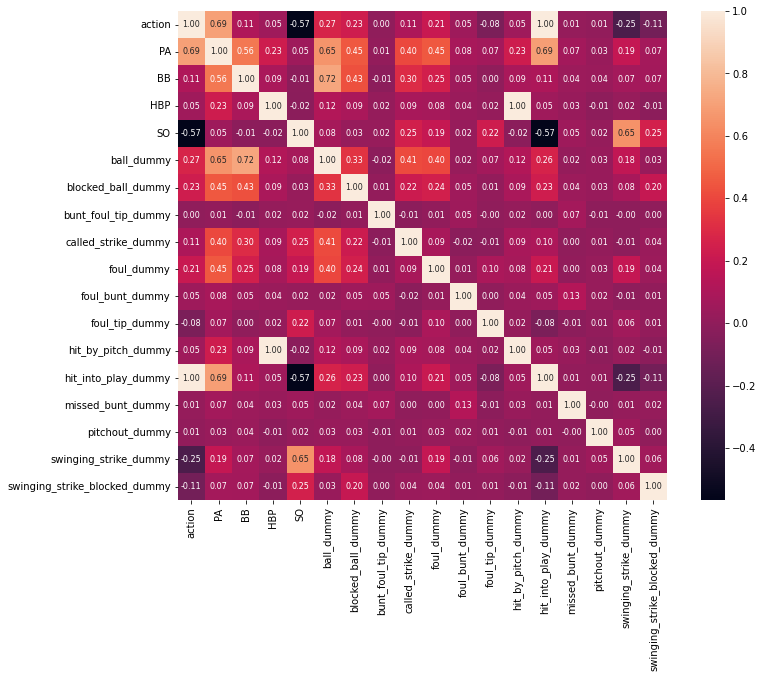

In [47]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, annot=True, fmt='.2f', annot_kws={'size': 8});

# group data by team

In [48]:
data_final_team = data_final.groupby('batting_team').agg({'ball_dummy':sum, 'blocked_ball_dummy':sum, 'bunt_foul_tip_dummy':sum, 
                              'called_strike_dummy':sum, 'foul_dummy':sum, 'foul_bunt_dummy':sum, 
                              'foul_tip_dummy':sum, 'hit_by_pitch_dummy':sum, 'hit_into_play_dummy':sum,
                              'missed_bunt_dummy':sum, 'pitchout_dummy':sum, 'swinging_strike_dummy': sum,
                              'swinging_strike_blocked_dummy':sum, 'PA':sum, 'BB':sum, 'HBP':sum, 'SO':sum, 'action':sum})

In [49]:
data_final_team.head()

,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,PA,BB,HBP,SO,action
batting_team,,,,,,,,,,,,,,,,,,
ARI,7983.0,558.0,1,4225.0,4169.0,50,214.0,54,4040.0,13,0,2505.0,156,6080,532,54,1450,4044
ATL,7445.0,529.0,2,3142.0,4196.0,45,237.0,66,3781.0,17,1,2636.0,121,5734,522,66,1363,3783
BAL,7349.0,519.0,0,3689.0,4120.0,43,268.0,61,3848.0,10,0,2578.0,171,5741,432,61,1399,3849
BOS,7430.0,587.0,1,3632.0,4215.0,18,233.0,60,3962.0,4,0,2540.0,149,5828,489,60,1315,3964
CHC,7516.0,546.0,0,3849.0,3851.0,78,213.0,87,3622.0,20,1,2569.0,191,5708,478,87,1519,3624


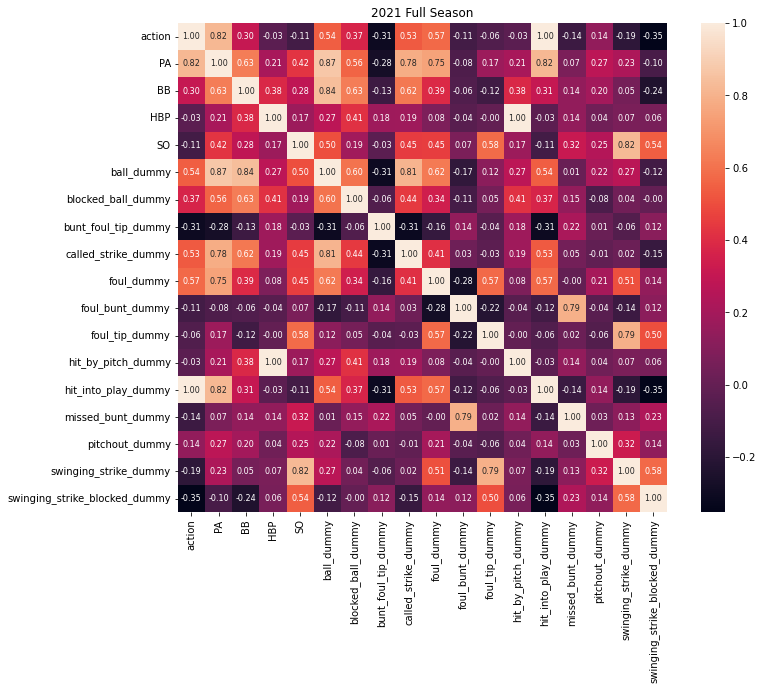

In [50]:
var_corr = ['action','PA', 'BB', 'HBP', 'SO', 'ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy']
corr_df = data_final_team[var_corr]
corrmat = corr_df.corr()

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, annot=True, fmt='.2f', annot_kws={'size': 8});
ax.set_title('2021 Full Season')
plt.show()

# train/test split 

In [51]:
train_df, test_df = train_test_split(data_final, test_size=0.2, random_state=0, shuffle=True)

In [52]:
train_df.shape

(3697, 22)

In [53]:
test_df.shape

(925, 22)

# regression

In [54]:
predictors = ['ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy']
response = 'PA'

results = func.fit_ols(predictors, response, train_df)


/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     PA   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     1949.
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:52:14   Log-Likelihood:                -7154.8
No. Observations:                3697   AIC:                         1.434e+04
Df Residuals:                    3683   BIC:                         1.442e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [56]:
var_selected = func.stepwise(predictors, response, 0.15, train_df, show=False)

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/op

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/op

----------------------------------------------------
Stepwise Complete
Total Rounds: 13
Features Selected: ['ball_dummy', 'hit_into_play_dummy', 'swinging_strike_dummy', 'called_strike_dummy', 'hit_by_pitch_dummy', 'blocked_ball_dummy', 'foul_dummy', 'swinging_strike_blocked_dummy', 'foul_tip_dummy', 'foul_bunt_dummy', 'missed_bunt_dummy', 'bunt_foul_tip_dummy']


/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/op

In [57]:
var_selected

['ball_dummy',
 'hit_into_play_dummy',
 'swinging_strike_dummy',
 'called_strike_dummy',
 'hit_by_pitch_dummy',
 'blocked_ball_dummy',
 'foul_dummy',
 'swinging_strike_blocked_dummy',
 'foul_tip_dummy',
 'foul_bunt_dummy',
 'missed_bunt_dummy',
 'bunt_foul_tip_dummy']

looks like all but pitchout were selected

In [58]:
results = func.fit_ols(var_selected, response, train_df)

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [59]:
y_pred = func.predict_ols(var_selected, response, results, test_df)

In [60]:
y_test = test_df['PA']

In [61]:
mse = sme.mse(y_pred, y_test, axis=0)
mse

2.7055729915408704

MSE: 2.805; RMSE: 1.675; RMSPE: 0.441; MEANABS: 1.318; MEDIANABS: 1.095


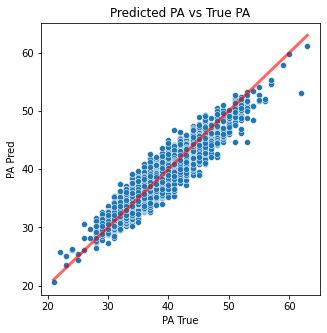

In [62]:
predictors = var_selected
response = 'PA'
data = data_final
num_fold=5
    
kf = KFold(n_splits=num_fold, random_state=0, shuffle=True)

mse_list = []
rmse_list = []
rmspe_list = []
meanabs_list = []
medianabs_list = []
y_predAll = []
y_testAll = []
for train_index, test_index in kf.split(data):
    X_train = data.iloc[train_index][predictors]
    X_train = sm.add_constant(X_train)
    y_train = data.iloc[train_index][response]
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    X_test = data.iloc[test_index][predictors]
    X_test = sm.add_constant(X_test)
    y_pred = results.predict(X_test)
    y_test = data.iloc[test_index][response]

    mse = sme.mse(y_pred, y_test, axis=0)
    rmse = sme.rmse(y_pred, y_test, axis=0)
    rmspe = sme.rmspe(y_pred, y_test, axis=0)
    meanabs = sme.meanabs(y_pred, y_test, axis=0)
    medianabs = sme.medianabs(y_pred, y_test, axis=0)

    mse_list.append(mse)
    rmse_list.append(rmse)
    rmspe_list.append(rmspe)
    meanabs_list.append(meanabs)
    medianabs_list.append(medianabs)
    y_predAll = np.append(y_predAll, y_pred)
    y_testAll = np.append(y_testAll, y_test)

avg_mse = round(sum(mse_list)/len(mse_list), 3)
avg_rmse = round(sum(rmse_list)/len(rmse_list), 3)
avg_rmspe = round(sum(rmspe_list)/len(rmspe_list), 3)
avg_meanabs = round(sum(meanabs_list)/len(meanabs_list), 3)
avg_medianabs = round(sum(medianabs_list)/len(medianabs_list), 3)

print(f"MSE: {avg_mse}; RMSE: {avg_rmse}; RMSPE: {avg_rmspe}; MEANABS: {avg_meanabs}; MEDIANABS: {avg_medianabs}")

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.scatterplot(x=y_testAll, y=y_predAll)
plt.plot([y_testAll.min(), y_testAll.max()], [y_testAll.min(), y_testAll.max()], linewidth=3, color='red', alpha=0.6)
ax.set(xlabel='PA True', ylabel='PA Pred')
ax.set_title('Predicted PA vs True PA')
plt.show()

mse_list = mse_list
rmse_list = rmse_list
rmspe_list = rmspe_list
meanabs_list = meanabs_list
medianabs_list = medianabs_list
y_test = y_testAll
y_pred = y_predAll

In [63]:
avg_error_pct = sum(abs(y_pred - y_test)/y_test)/len(y_test)
avg_error_pct = round(avg_error_pct * 100, 3)
print(f"Prediction is off by {avg_error_pct}% on avg")

Prediction is off by 3.498% on avg


In [64]:
var_list = data_final.columns.values[4:-6]

In [65]:
data_total = data_final[var_list].copy()
for var in var_list:
    data_total[var] = data_final[var].sum()/data_final.shape[0]

In [66]:
data_total

,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy
0,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
1,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
2,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
3,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
4,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
...,...,...,...,...,...,...,...,...,...,...,...,...
4617,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
4618,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
4619,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502
4620,49.286023,3.598226,0.008871,24.302899,26.191043,0.322155,1.395932,0.440286,25.321939,0.074643,0.00714,15.731502


# regression on other vars

In [67]:
# stepwise
var_selected = func.stepwise(predictors, 'action', 0.15, train_df, show=False)

----------------------------------------------------
Stepwise Complete
Total Rounds: 6
Features Selected: ['hit_into_play_dummy', 'swinging_strike_blocked_dummy', 'foul_dummy', 'called_strike_dummy']


/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/op

In [68]:
predictors = ['ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy']

predictors = ['swinging_strike_dummy']
response = 'SO'

results = func.fit_ols(predictors, response, train_df)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     SO   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2606.
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:52:15   Log-Likelihood:                -8197.9
No. Observations:                3697   AIC:                         1.640e+04
Df Residuals:                    3695   BIC:                         1.641e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.86

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [69]:
train_df

,game_pk,date_time,batting_team,Opp,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,PA,BB,HBP,SO,action
2258,633174,2021-07-25,TOR,NYM,38,2,0,28,19,1,1,1,28,0,0,9,0,40,4,1,7,28
4601,632501,2021-09-11,WSH,PIT,66,10,0,32,29,1,0,1,29,0,0,14,2,43,5,1,8,29
4395,633508,2021-06-29,STL,ARI,46,1,0,29,30,2,1,2,21,0,0,16,0,36,4,2,9,21
3722,634244,2021-05-03,PHI,MIL,51,4,0,25,27,0,1,0,23,0,0,7,1,32,2,0,7,23
1519,632458,2021-09-17,NYY,CLE,44,2,0,25,20,0,1,0,26,0,0,20,0,36,2,0,8,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,632770,2021-08-23,KC,HOU,56,5,0,20,35,0,0,0,35,0,0,18,0,43,4,0,4,35
3264,634450,2021-04-17,MIA,SF,66,9,0,36,34,0,0,3,34,0,0,18,0,53,6,3,10,34
1653,632823,2021-08-19,OAK,CWS,58,6,0,25,21,0,2,0,25,0,0,15,3,40,7,0,8,25
2607,632538,2021-09-11,ATL,MIA,49,3,0,32,34,0,0,1,29,0,0,18,1,40,1,1,9,29
